# Naive Bayes

## Application of Gaussian Naive Bayes


### Setup

In [1]:
# Common imports
import sklearn
import numpy as np

### Datasets

#### Forest CoverType dataset
* Characteristic data of forest covertype
* Predict which type of covertype belongs to
* https://archive.ics.uci.edu/ml/datasets/Covertype 
* $Y$: discrete, 
  * $X_{0 ∼ 9}$: continuous
  * $X_{10 ∼ 53}$: discrete

In [ ]:
from sklearn.datasets import fetch_covtype
import pandas as pd

covtype = fetch_covtype()
covtype_X = covtype.data[:,0:10] #continuous features for Gaussian model
covtype_y = covtype.target
covtype_feature_names = covtype.feature_names[0:10]
covtype_class_names = covtype.target_names

print('Number of targets: ',len(covtype_class_names))

# combine features and class data
covtype_np = np.append(covtype_X, covtype_y.reshape(-1,1), axis=1)
covtype_col_names = covtype_feature_names + ['class']

covtype_pd = pd.DataFrame(covtype_np, columns=covtype_col_names)
covtype_pd.head(3)

#### Dataset Visualization

* correlation of features

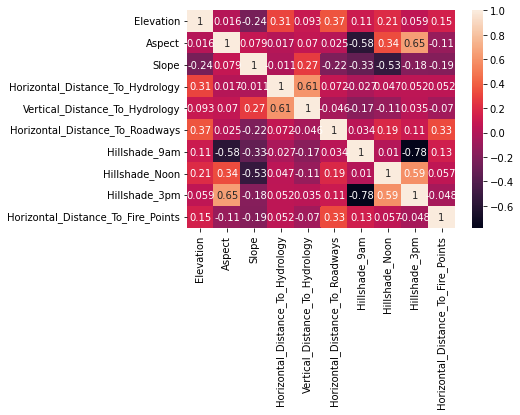

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

covtype_X_pd = pd.DataFrame(covtype_X, columns=covtype_feature_names)
sns.heatmap(covtype_X_pd.corr(),annot=True)
plt.show()

In [ ]:
print(covtype_X_pd.var(axis=0))

Elevation                             7.839145e+04
Aspect                                1.252468e+04
Slope                                 5.607377e+01
Horizontal_Distance_To_Hydrology      4.517723e+04
Vertical_Distance_To_Hydrology        3.398334e+03
Horizontal_Distance_To_Roadways       2.431276e+06
Hillshade_9am                         7.166269e+02
Hillshade_Noon                        3.908014e+02
Hillshade_3pm                         1.464940e+03
Horizontal_Distance_To_Fire_Points    1.753493e+06
dtype: float64


### Gaussian Naive Bayes Classifier

* Assume that the input features have a Gaussian (normal) distribution
* ${\prod_{j=1}^J\frac{1}{\sqrt{2π𝞼_c^2}}exp(-\frac{(x_i-μ_c)^2}{2𝞼_c^2})P(y=c)}_{max}$
* Estimating Parameters: $Y$: discrete, $X_{i}$: continuous

**- sklearn.naive_bayes.[GaussianNB(*, priors=None, var_smoothing=1e-09)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) : Returns the instance itself.**

Can perform online updates to model parameters via partial_fit.

In [ ]:
# Default model
from sklearn.naive_bayes import GaussianNB
gaussian_model = GaussianNB()

#### train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X, covtype_y, random_state=42)

#### Comparison with features

In [ ]:
from sklearn import metrics

for idx, feature in enumerate(covtype_feature_names):
  gaussian_model.fit(covtype_X_train[:,[idx]], covtype_y_train)
  predict = gaussian_model.predict(covtype_X_test[:,[idx]])
  acc = metrics.accuracy_score(covtype_y_test, predict)
  print('Test Accuracy({}): {}'.format(feature,acc))

#### Set parameters(var_smoothing)
**var_smoothing**
* default: float, 1e-09
* Portion of the largest variance of all features that is added to variances for calculation stability.


내부 코드
```python
self.epsilon_ = self.var_smoothing * np.var(X, axis=0).max()
...
self.var_[:, :] += self.epsilon_
```



**Variance Smoothing**
  * 차원 간의 데이터 분산 비율이 너무 작으면 수치 오류가 발생합니다. 이 문제를 해결하기 위해 가장 큰 차원의 표준 편차의 작은 부분인 엡실론만큼 분산을 인위적으로 높입니다.
  * 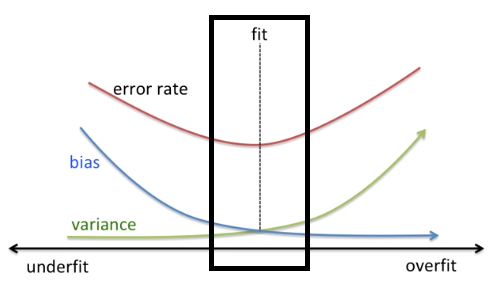

##### set_params

* var_smoothing $10^{-11}$ VS $10^{-2}$

In [ ]:
# Default model
from sklearn.naive_bayes import GaussianNB
gaussian_model = GaussianNB()

# var_smoothing=10**-11
gaussian_model.set_params(var_smoothing=10**-11)
gaussian_model.fit(covtype_X_train, covtype_y_train)

predict = gaussian_model.predict(covtype_X_train)
acc = metrics.accuracy_score(covtype_y_train, predict)
print('train Accuracy(var_smoothing=10**-11): {}'.format(acc))
predict = gaussian_model.predict(covtype_X_test)
acc = metrics.accuracy_score(covtype_y_test, predict)
print('Test Accuracy(var_smoothing=10**-11): {}'.format(acc))

# var_smoothing=10**2
gaussian_model.set_params(var_smoothing=10**-2)
gaussian_model.fit(covtype_X_train, covtype_y_train)

predict = gaussian_model.predict(covtype_X_train)
acc = metrics.accuracy_score(covtype_y_train, predict)
print('train Accuracy(var_smoothing=10**-2): {}'.format(acc))
predict = gaussian_model.predict(covtype_X_test)
acc = metrics.accuracy_score(covtype_y_test, predict)
print('Test Accuracy(var_smoothing=10**-2): {}'.format(acc))

#### Validation_curve

* Visualization 함수

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 수치형 파라미터 시각화 함수
def viz_val_curve(param_range, train_mean, train_std, test_mean, test_std, param_name, xscale_log=False):
  plt.plot(param_range, train_mean, 
          color='blue', marker='o', 
          markersize=5, label='Training accuracy')

  plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')

  plt.plot(param_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
          label='Validation accuracy')

  plt.fill_between(param_range, 
                  test_mean + test_std,
                  test_mean - test_std, 
                  alpha=0.15, color='green')


  plt.grid()
  plt.legend(loc='lower right')
  if xscale_log:
    plt.xscale('log')
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim([np.min(test_mean)*0.8, np.max(train_mean)*1.2])
  plt.tight_layout()
  plt.show()

# 범주형 파라미터 시각화 함수
def viz_val_bar(param_range, train_mean, train_std, test_mean, test_std, param_name):
  idx = np.arange(len(param_range))
  plt.bar(idx, test_mean, width=0.3)
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim([np.min(test_mean)*0.9, np.max(test_mean)*1.1])
  plt.xticks(idx, param_range, fontsize=15)
  plt.show()

**var_smoothing**
* default: float, 1e-09
* Portion of the largest variance of all features that is added to variances for calculation stability.

In [ ]:
from sklearn.model_selection import validation_curve
param_range= [10**i for i in range(-11,4)]
param_name='var_smoothing'

# Default model
from sklearn.naive_bayes import GaussianNB
gaussian_model = GaussianNB()

train_scores, test_scores = validation_curve(
                estimator=gaussian_model, 
                X=covtype_X, 
                y=covtype_y, 
                param_name=param_name, 
                param_range=param_range,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

viz_val_curve(param_range, train_mean, train_std, test_mean, test_std, param_name, True)

## Application of Multinomial Naive Bayes

### Setup

In [ ]:
# Common imports
import sklearn
import numpy as np

### Datasets

#### 20 Newsgroup dataset
* Categorize which group the news article belongs to
* News articles are text data, so special preprocessing is required.
* $Y$: discrete, $X$: discrete(Text)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

newsgroup = fetch_20newsgroups()
newsgroup_X = newsgroup.data
newsgroup_y = newsgroup.target
newsgroup_feature_names = ['text']
newsgroup_class_names = newsgroup.target_names

print('Number of targets: ',len(newsgroup_class_names))

# combine features and class data
newsgroup_np = np.append(np.reshape(newsgroup_X,(-1,1)), newsgroup_y.reshape(-1,1), axis=1)
newsgroup_col_names = newsgroup_feature_names + ['class']

newsgroup_pd = pd.DataFrame(newsgroup_np, columns=newsgroup_col_names)
newsgroup_pd.head(3)

### Preprocess

#### train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
newsgroup_X_train, newsgroup_X_test, newsgroup_y_train, newsgroup_y_test = train_test_split(newsgroup_X, newsgroup_y, random_state=42)

#### Vectorization for text data
* sklearn.feature_extraction.text.[CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
  * 문서를 토큰 리스트로 변환
  * 각 문서에서 토큰의 출현 빈도 카운트
  * 각 문서를 Bag of words(BOW) 인코딩 벡터로 변환
* sklearn.feature_extraction.text.[HashingVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer)
  * 해시 함수 사용으로 단어에 대한 index를 생성하여 실행시간 단축
  * binary 파라미터에 True 값을 주어 non-zero counts를 1로 세팅하여 데이터를 이진화 할 수 있음 
* sklearn.feature_extraction.text.[TfidfVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
  * 단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 가중치를 축소
  * $tf-idf(d, t)= tf(d, f)̇ ⋅ idf(t)$
    * $d, t$ : document, term
    * $tf(d,t)$ : term frequency.
    * $idf(t)$ : inverse document frequency.
    * $idf(d, t)= log\frac{n}{1+df(t)}$
      * $n$ : 전체 문서의 수
      * $df$ : 단어 $t$를 가진 문서의 수


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# count vectorizer
count_vectorizer = CountVectorizer() 
X_train_count = count_vectorizer.fit_transform(newsgroup_X_train)
X_test_count = count_vectorizer.transform(newsgroup_X_test)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(newsgroup_X_train)
X_test_tfidf = tfidf_vectorizer.transform(newsgroup_X_test)

### Multinomial Naive Bayes Classifier

* Assume that the input feature has a frequency value generated by a multinomial distribution
* ${\frac{(\sum_{j=1}^J xk)!}{\prod_{k=1}^Kxk!}\prod_{k=1}^K P_{c_k}^{x_k}}_{max}$
* Estimating Parameters: $Y, X_{i}$: discrete-valued

**- sklearn.naive_bayes.[MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) : Returns the instance itself.**

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [ ]:
from sklearn.naive_bayes import MultinomialNB

multinomial_model_count = MultinomialNB()
multinomial_model_count.fit(X_train_count, newsgroup_y_train)

multinomial_model_tfidf = MultinomialNB()
multinomial_model_tfidf.fit(X_train_tfidf, newsgroup_y_train)

#### Evaluation

In [ ]:
from sklearn import metrics

# use conut Vector
predict = multinomial_model_count.predict(X_train_count)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('Train Accuracy(count): {}'.format(acc))

predict = multinomial_model_count.predict(X_test_count)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(count): {}'.format(acc))

# use TF-IDF Vector
predict = multinomial_model_tfidf.predict(X_train_tfidf)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('Train Accuracy(tfidf): {}'.format(acc))
predict = multinomial_model_tfidf.predict(X_test_tfidf)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(tfidf): {}'.format(acc))


#### Set parameter (alpha)
**alpha**
* float, default=1.0
* Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
* 모수가 0이나 1이 나오는 경우 극단적인 값을 추론하므로 alpha값을 분자에 더해줌

```python
smoothed_fc = self.feature_count_ + alpha
```



**Laplace Smoothing**
  * 새로운 데이터가 등장하면 확률이 0이 되므로, 클래스 개수에 k배를 해주어 분모와 분자에 더함.
  * 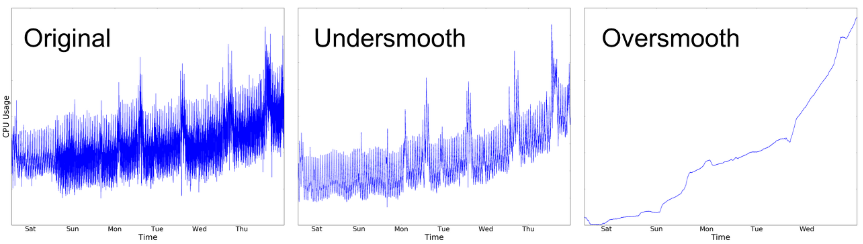
    * https://dawn.cs.stanford.edu/2017/08/07/asap/

##### set_params

* alpha $10^{-6}$ VS $10^{-2}$

In [ ]:
# Default model
from sklearn.naive_bayes import MultinomialNB
multinomial_model_tfidf = MultinomialNB()

# alpha=10**-6
multinomial_model_tfidf.set_params(alpha=10**-6)
multinomial_model_tfidf.fit(X_train_tfidf, newsgroup_y_train)

predict = multinomial_model_tfidf.predict(X_train_tfidf)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('train Accuracy(alpha=10**-6): {}'.format(acc))
predict = multinomial_model_tfidf.predict(X_test_tfidf)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(alpha=10**-6): {}'.format(acc))

# alpha=10**-2
multinomial_model_tfidf.set_params(alpha=10**-2)
multinomial_model_tfidf.fit(X_train_tfidf, newsgroup_y_train)

predict = multinomial_model_tfidf.predict(X_train_tfidf)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('train Accuracy(alpha=10**-2): {}'.format(acc))
predict = multinomial_model_tfidf.predict(X_test_tfidf)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(alpha=10**-2): {}'.format(acc))

#### Validation_curve

* Visualization 함수

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 수치형 파라미터 시각화 함수
def viz_val_curve(param_range, train_mean, train_std, test_mean, test_std, param_name, xscale_log=False):
  plt.plot(param_range, train_mean, 
          color='blue', marker='o', 
          markersize=5, label='Training accuracy')

  plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')

  plt.plot(param_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
          label='Validation accuracy')

  plt.fill_between(param_range, 
                  test_mean + test_std,
                  test_mean - test_std, 
                  alpha=0.15, color='green')


  plt.grid()
  plt.legend(loc='lower right')
  if xscale_log:
    plt.xscale('log')
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim([np.min(test_mean)*0.8, np.max(train_mean)*1.2])
  plt.tight_layout()
  plt.show()

# 범주형 파라미터 시각화 함수
def viz_val_bar(param_range, train_mean, train_std, test_mean, test_std, param_name):
  idx = np.arange(len(param_range))
  plt.bar(idx, test_mean, width=0.3)
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim([np.min(test_mean)*0.9, np.max(test_mean)*1.1])
  plt.xticks(idx, param_range, fontsize=15)
  plt.show()

**alpha**
* float, default=1.0
* Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
* 모수가 0이나 1이 나오는 경우 극단적인 값을 추론하므로 alpha값을 분자에 더해줌

In [ ]:
from sklearn.model_selection import validation_curve
param_range= [10**i for i in range(-6,1)]
param_name='alpha'

from sklearn.naive_bayes import MultinomialNB
multinomial_model_tfidf = MultinomialNB()

from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(newsgroup_X)

train_scores, test_scores = validation_curve(
                estimator=multinomial_model_tfidf, 
                X=X_tfidf, 
                y=newsgroup_y, 
                param_name=param_name, 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

viz_val_curve(param_range, train_mean, train_std, test_mean, test_std, param_name, True)

## Application of Bernoulli Naive Bayes

### Setup

In [ ]:
# Common imports
import sklearn
import numpy as np

### Datasets

#### 20 Newsgroup dataset
* Categorize which group the news article belongs to
* News articles are text data, so special preprocessing is required.
* $Y$: discrete, $X$: discrete(Text)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

newsgroup = fetch_20newsgroups()
newsgroup_X = newsgroup.data
newsgroup_y = newsgroup.target
newsgroup_feature_names = ['text']
newsgroup_class_names = newsgroup.target_names

print('Number of targets: ',len(newsgroup_class_names))

# combine features and class data
newsgroup_np = np.append(np.reshape(newsgroup_X,(-1,1)), newsgroup_y.reshape(-1,1), axis=1)
newsgroup_col_names = newsgroup_feature_names + ['class']

newsgroup_pd = pd.DataFrame(newsgroup_np, columns=newsgroup_col_names)
newsgroup_pd.head(3)

### Preprocess

#### train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
newsgroup_X_train, newsgroup_X_test, newsgroup_y_train, newsgroup_y_test = train_test_split(newsgroup_X, newsgroup_y, random_state=42)

#### Vectorization for text data
* sklearn.feature_extraction.text.[CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
  * 문서를 토큰 리스트로 변환
  * 각 문서에서 토큰의 출현 빈도 카운트
  * 각 문서를 Bag of words(BOW) 인코딩 벡터로 변환
* sklearn.feature_extraction.text.[HashingVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer)
  * 해시 함수 사용으로 단어에 대한 index를 생성하여 실행시간 단축
* sklearn.feature_extraction.text.[TfidfVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
  * 단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 가중치를 축소
  * $tf-idf(d, t)= tf(d, f)̇ ⋅ idf(t)$
    * $d, t$ : document, term
    * $tf(d,t)$ : term frequency.
    * $idf(t)$ : inverse document frequency.
    * $idf(d, t)= log\frac{n}{1+df(t)}$
      * $n$ : 전체 문서의 수
      * $df$ : 단어 $t$를 가진 문서의 수


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# count vectorizer
count_vectorizer = CountVectorizer() 
X_train_count = count_vectorizer.fit_transform(newsgroup_X_train)
X_test_count = count_vectorizer.transform(newsgroup_X_test)

# Hashing Vectoizer
hash_vectorizer = HashingVectorizer(n_features=1000)
X_train_hash = hash_vectorizer.fit_transform(newsgroup_X_train)
X_test_hash = hash_vectorizer.transform(newsgroup_X_test)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(newsgroup_X_train)
X_test_tfidf = tfidf_vectorizer.transform(newsgroup_X_test)

In [ ]:
stop_words = count_vectorizer.get_stop_words()
print(stop_words)

### Bernoulli Naive Bayes Classifier

* Assume that the input features have binary values ​​generated by the Bernoulli distribution.
* ${\prod_{j=1}^J\frac{(\sum_{j=1}^J xk)!}{\prod_{k=1}^Kxk!}P_{ck}^{xk}P(y=c)}_{max}$
* Estimating Parameters: $X_{i}$: binomial-valued

**- sklearn.naive_bayes.[BernoulliNB(*, alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) : Returns the instance itself.**

this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

In [ ]:
from sklearn.naive_bayes import BernoulliNB

#count
bernoulli_model_count = BernoulliNB()
bernoulli_model_count.fit(X_train_count, newsgroup_y_train)

# Hash
bernoulli_model_hash = BernoulliNB()
bernoulli_model_hash.fit(X_train_hash, newsgroup_y_train)

# Tf-idf
bernoulli_model_tfidf = BernoulliNB()
bernoulli_model_tfidf.fit(X_train_tfidf, newsgroup_y_train)

#### Evaluation

In [ ]:
from sklearn import metrics

# use conut Vector
predict = bernoulli_model_count.predict(X_train_count)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('Train Accuracy(count): {}'.format(acc))

predict = bernoulli_model_count.predict(X_test_count)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(count): {}'.format(acc))

# use Hash Vector
predict = bernoulli_model_hash.predict(X_train_hash)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('Train Accuracy(hash): {}'.format(acc))
predict = bernoulli_model_hash.predict(X_test_hash)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(hash): {}'.format(acc))

# use TF-IDF Vector
predict = bernoulli_model_tfidf.predict(X_train_tfidf)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('Train Accuracy(tfidf): {}'.format(acc))
predict = bernoulli_model_tfidf.predict(X_test_tfidf)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(tfidf): {}'.format(acc))

### Set parameters(alpha, binarize)
**alpha**
* float, default=1.0
* Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

**binarize**
* float, default=0.0
* Threshold for binarizing (mapping to booleans) of sample features. If None, input is presumed to already consist of binary vectors

##### set_params

* alpha $10^{-10}$ VS $10^{-1}$

In [ ]:
# Default model
from sklearn.naive_bayes import MultinomialNB
multinomial_model_tfidf = MultinomialNB()

from sklearn.naive_bayes import BernoulliNB
bernoulli_model_count = BernoulliNB()


# alpha=10**-10
bernoulli_model_count.set_params(alpha=10**-10)
bernoulli_model_count.fit(X_train_count, newsgroup_y_train)

(X_train_count, newsgroup_y_train)

predict = bernoulli_model_count.predict(X_train_count)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('train Accuracy(alpha=10**-10): {}'.format(acc))
predict = bernoulli_model_count.predict(X_test_count)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(alpha=10**-10): {}'.format(acc))

# alpha=10**-1
bernoulli_model_count.set_params(alpha=10**-1)
bernoulli_model_count.fit(X_train_count, newsgroup_y_train)

predict = bernoulli_model_count.predict(X_train_count)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('train Accuracy(alpha=10**-1): {}'.format(acc))
predict = bernoulli_model_count.predict(X_test_count)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(alpha=10**-1): {}'.format(acc))

* binarize $0$ VS $2$

In [ ]:
# Default model
from sklearn.naive_bayes import MultinomialNB
multinomial_model_tfidf = MultinomialNB()

from sklearn.naive_bayes import BernoulliNB
bernoulli_model_count = BernoulliNB()


# binarize=0
bernoulli_model_count.set_params(binarize=0)
bernoulli_model_count.fit(X_train_count, newsgroup_y_train)

(X_train_count, newsgroup_y_train)

predict = bernoulli_model_count.predict(X_train_count)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('train Accuracy(binarize=0): {}'.format(acc))
predict = bernoulli_model_count.predict(X_test_count)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(binarize=0): {}'.format(acc))

# binarize=2
bernoulli_model_count.set_params(binarize=2)
bernoulli_model_count.fit(X_train_count, newsgroup_y_train)

predict = bernoulli_model_count.predict(X_train_count)
acc = metrics.accuracy_score(newsgroup_y_train, predict)
print('train Accuracy(binarize=2): {}'.format(acc))
predict = bernoulli_model_count.predict(X_test_count)
acc = metrics.accuracy_score(newsgroup_y_test, predict)
print('Test Accuracy(binarize=2): {}'.format(acc))

### Validation_curve(alpha)

* Visualization 함수

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 수치형 파라미터 시각화 함수
def viz_val_curve(param_range, train_mean, train_std, test_mean, test_std, param_name, xscale_log=False):
  plt.plot(param_range, train_mean, 
          color='blue', marker='o', 
          markersize=5, label='Training accuracy')

  plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')

  plt.plot(param_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
          label='Validation accuracy')

  plt.fill_between(param_range, 
                  test_mean + test_std,
                  test_mean - test_std, 
                  alpha=0.15, color='green')


  plt.grid()
  plt.legend(loc='lower right')
  if xscale_log:
    plt.xscale('log')
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim([np.min(test_mean)*0.8, np.max(train_mean)*1.2])
  plt.tight_layout()
  plt.show()

# 범주형 파라미터 시각화 함수
def viz_val_bar(param_range, train_mean, train_std, test_mean, test_std, param_name):
  idx = np.arange(len(param_range))
  plt.bar(idx, test_mean, width=0.3)
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim([np.min(test_mean)*0.9, np.max(test_mean)*1.1])
  plt.xticks(idx, param_range, fontsize=15)
  plt.show()

**alpha**
* float, default=1.0
* Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

In [ ]:
from sklearn.model_selection import validation_curve
param_range= [10**i for i in range(-10,-1)]
param_name='alpha'

from sklearn.naive_bayes import BernoulliNB
bernoulli_model_count = BernoulliNB()

from sklearn.feature_extraction.text import CountVectorizer
# Count Vectorizer
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(newsgroup_X)

(X_train_count, newsgroup_y_train)

train_scores, test_scores = validation_curve(
                estimator=bernoulli_model_count, 
                X=X_count, 
                y=newsgroup_y, 
                param_name=param_name, 
                param_range=param_range,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

viz_val_curve(param_range, train_mean, train_std, test_mean, test_std, param_name, True)

# Exercise

## 1번 문제 (Gaussian Naive Bayes)

Gausian Naive Bayes model을 사용하여 fetch_california_housing 데이터를 분류 하시오.
  * Validation_curve 함수를 사용하여 아래 Hyperparameters의 변화에 따른 결과를 그래프로 표현하시오.
    * var_smoothing
  * 가장 높은 accuracy를 기록하는 파리미터를 도출하시오.

```python
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()
housing_X = housing.data

# discrete한 y 데이터로 변경하기 위해 소수점 자리를 반올림하여 int로 형변환
housing_y = np.round(housing.target).astype(int) # make y discrete
print('Number of target: ',len(set(housing_y)))

pd.DataFrame(housing_X, columns=housing.feature_names).head(3)

```

## 1번 문제 답안

## 2번 문제 (Bernoulli Naive Bayes)
Bernoulli Naive Bayes model을 사용하여 Forest CoverType index 10~53까지의 데이터를 분류 하시오.
  * Validation_curve 함수를 사용하여 아래 Hyperparameters의 변화에 따른 결과를 그래프로 표현하시오.
    * alpha
  * 가장 높은 accuracy를 기록하는 파리미터를 도출하시오.

```python
from sklearn.datasets import fetch_covtype
import pandas as pd

covtype = fetch_covtype()
# covtype index 10~53
bi_covtype_X = covtype.data[:,10:53] #discrete features for Bernoulli model
bi_covtype_y = covtype.target

covtype_feature_name = covtype.feature_names[10:53]
print('Number of targets: ',len(set(bi_covtype_y)))

pd.DataFrame(bi_covtype_X, columns=covtype_feature_name).head(3)
```



## 2번 문제 답안

## 3번 문제(Multinomial Naive Bayes) 

Multinomial Naive Bayes model을 사용하여 20 Newsgroup 데이터를 분류 하시오.
  * Hashing Vectoizer를 사용하여 text features를 vectorize 하시오.
    * Hashing Vectoizer의 파라미터 binary에 True값을 할당하여 데이터를 이진 데이터로 벡터화 하시오.

  ```python
  from sklearn.feature_extraction.text import HashingVectorizer

  # Hashing Vectoizer
  hash_vectorizer = HashingVectorizer(n_features=1000, binary=True)
  ```
  * Validation_curve 함수를 사용하여 아래 Hyperparameters의 변화에 따른 결과를 그래프로 표현하시오.
    * alpha
  * 가장 높은 accuracy를 기록하는 파리미터를 도출하시오.

## 3번 문제 답안